In [5]:
import glob 
import numpy as np 
import os 
import shutil 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
#from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model 
from keras.applications.inception_resnet_v2 import preprocess_input
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers  

In [6]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))        

In [7]:
IM_SHAPE=(224,224)
input_shape=(IM_SHAPE[0],IM_SHAPE[1],3)

In [8]:
batch_size = 32
num_classes = 2 
epochs = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                                      validation_split=0.2)

# train_generator = train_datagen.flow_from_directory(
#     '../input/covidog/dataset',
#     target_size=IM_SHAPE,

#     batch_size=batch_size,
#     class_mode='categorical') # set as training data

train_generator_NEW = train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train', # same directory as training data
    target_size=IM_SHAPE,
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
validation_generator_NEW= train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train',
#     batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE
)
test_generator_NEW=val_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Test',
    #batch_size=16,
    class_mode='categorical',
    target_size=IM_SHAPE
)

Found 14461 images belonging to 2 classes.
Found 6196 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
#from keras.applications import DenseNet121

from keras.applications import vgg19
vgg =  vgg19.VGG19(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

#vgg_model.summary()

2023-01-30 23:25:38.369865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 23:25:38.468340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 23:25:38.469126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 23:25:38.470899: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 4s 0us/step


In [10]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fe7fc702710>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7fe7f1600a50>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7fe7f1600d90>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7fe7f80b12d0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7fe7f80b1f50>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7fe7f80b1610>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7fe7f80c2290>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7fe7f80c9a90>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7fe7f80c2d10>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7fe7f80fccd0>,block3_conv3,False


In [11]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


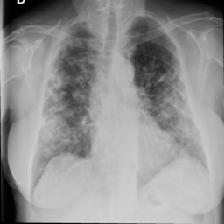

In [12]:
array_to_img(train_generator_NEW[0][0][0])

2023-01-30 23:25:46.558307: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-30 23:25:47.550853: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 7, 7, 512)


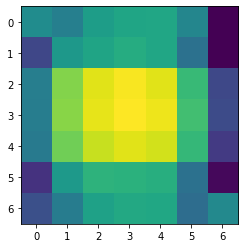

In [13]:
bottleneck_feature_example = vgg.predict(train_generator_NEW[0][0])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [14]:
model_TF = Sequential() 

model_TF.add(vgg_model) 
model_TF.add(Dense(1024, activation='relu')) 
model_TF.add(Dropout(0.25)) 
model_TF.add(Dense(512, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(256, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(num_classes, activation='sigmoid'))

model_TF.summary()

model_TF.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 25088)             20024384  
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [15]:
# history_TF = model_TF.fit(train_generator_NEW, 
#                               epochs=15,  
#                               validation_data=validation_generator_NEW,  
#                               verbose=1)

In [16]:
history_TF = model_TF.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


452/452 [==============================] - 187s 413ms/step - loss: 0.7182 - accuracy: 0.5076 - f1_m: 0.3889 - precision_m: 0.5083 - recall_m: 0.3529 - val_loss: 0.6964 - val_accuracy: 0.5303 - val_f1_m: 0.5302 - val_precision_m: 0.5302 - val_recall_m: 0.5302
Epoch 2/15
452/452 [==============================] - 68s 150ms/step - loss: 0.6951 - accuracy: 0.5146 - f1_m: 0.4522 - precision_m: 0.5130 - recall_m: 0.4192 - val_loss: 0.6928 - val_accuracy: 0.5303 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/15
452/452 [==============================] - 64s 142ms/step - loss: 0.6917 - accuracy: 0.5286 - f1_m: 0.5165 - precision_m: 0.5224 - recall_m: 0.5161 - val_loss: 0.6915 - val_accuracy: 0.5303 - val_f1_m: 0.5303 - val_precision_m: 0.5303 - val_recall_m: 0.5303
Epoch 4/15
452/452 [==============================] - 65s 143ms/step - loss: 0.6914 - accuracy: 0.5304 - f1_m: 0.5304 - precision_m: 0.5304 - recall_m: 0.5304 - val_loss: 0.6913 - val_accurac

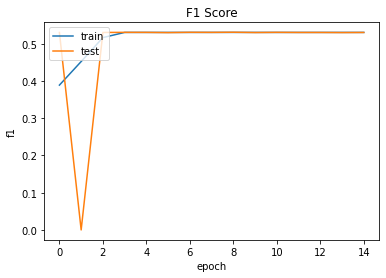

In [17]:
plt.plot(history_TF.history['f1_m'])
plt.plot(history_TF.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
test_loss= model_TF.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 18s 290ms/step - loss: 0.6946 - accuracy: 0.5000 - f1_m: 0.4980 - precision_m: 0.4980 - recall_m: 0.4980


In [19]:
test_loss

[0.6946290731430054,
 0.5,
 0.4980158507823944,
 0.4980158805847168,
 0.4980158805847168]

In [20]:
from keras.applications import vgg19
dense =  vgg19.VGG19(include_top=False,  
                                     input_shape=input_shape) 
output = dense.layers[-1].output 
output = keras.layers.Flatten()(output) 
dense_model = Model(dense.input, output) 
dense_model.trainable = True


In [21]:
model = Sequential() 

model.add(dense_model) 
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.25)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid'))



model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 25088)             20024384  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [23]:
history = model.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15
452/452 [==============================] - 135s 292ms/step - loss: 0.6968 - accuracy: 0.5214 - f1_m: 0.5642 - precision_m: 0.5132 - recall_m: 0.6338 - val_loss: 0.6918 - val_accuracy: 0.5303 - val_f1_m: 0.5302 - val_precision_m: 0.5302 - val_recall_m: 0.5302
Epoch 2/15
452/452 [==============================] - 130s 287ms/step - loss: 0.6915 - accuracy: 0.5300 - f1_m: 0.5303 - precision_m: 0.5283 - recall_m: 0.5331 - val_loss: 0.6914 - val_accuracy: 0.5303 - val_f1_m: 0.5307 - val_precision_m: 0.5307 - val_recall_m: 0.5307
Epoch 3/15
452/452 [==============================] - 129s 286ms/step - loss: 0.6914 - accuracy: 0.5304 - f1_m: 0.5304 - precision_m: 0.5304 - recall_m: 0.5304 - val_loss: 0.6913 - val_accuracy: 0.5303 - val_f1_m: 0.5304 - val_precision_m: 0.5304 - val_recall_m: 0.5304
Epoch 4/15
452/452 [==============================] - 130s 286ms/step - loss: 0.6914 - accuracy: 0.5304 - f1_m: 0.5304 - precision_m: 0.5304 - recall_m: 0.5304 - val_loss: 0.6913 - val_accur

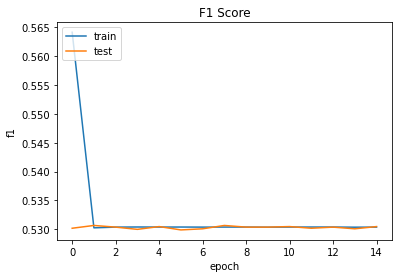

In [24]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
test_loss= model.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 6s 101ms/step - loss: 0.6950 - accuracy: 0.5000 - f1_m: 0.5005 - precision_m: 0.5005 - recall_m: 0.5005


In [26]:
test_loss

[0.6950262188911438,
 0.5,
 0.5004960298538208,
 0.5004960298538208,
 0.5004960298538208]